In [252]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, roc_auc_score, classification_report
from sklearn.metrics import ConfusionMatrixDisplay
import joblib

In [253]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [254]:
df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Mini Project Advance Python/Insurance/Insurance/insurance_data.csv')

In [255]:
index = len(df) - 1000
tmp = df
df = tmp[:index]
val = tmp[index:]

In [256]:
print('Shape of training data:', df.shape)
print('Shape of validation data:', val.shape)

Shape of training data: (380109, 12)
Shape of validation data: (1000, 12)


# Data Understanding

In [257]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 380109 entries, 0 to 380108
Data columns (total 12 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   id                    380109 non-null  int64  
 1   Gender                380109 non-null  object 
 2   Age                   380109 non-null  int64  
 3   Driving_License       380109 non-null  int64  
 4   Region_Code           380109 non-null  float64
 5   Previously_Insured    380109 non-null  int64  
 6   Vehicle_Age           380109 non-null  object 
 7   Vehicle_Damage        380109 non-null  object 
 8   Annual_Premium        380109 non-null  float64
 9   Policy_Sales_Channel  380109 non-null  float64
 10  Vintage               380109 non-null  int64  
 11  Response              380109 non-null  int64  
dtypes: float64(3), int64(6), object(3)
memory usage: 34.8+ MB


In [258]:
df.isna().sum()

,0
id,0
Gender,0
Age,0
Driving_License,0
Region_Code,0
Previously_Insured,0
Vehicle_Age,0
Vehicle_Damage,0
Annual_Premium,0
Policy_Sales_Channel,0


In [259]:
for col in df.columns:
    print(f'{col}: {df[col].nunique()}')

id: 380109
Gender: 2
Age: 66
Driving_License: 2
Region_Code: 53
Previously_Insured: 2
Vehicle_Age: 3
Vehicle_Damage: 2
Annual_Premium: 48813
Policy_Sales_Channel: 155
Vintage: 290
Response: 2


In [260]:
df.head()

,id,Gender,Age,Driving_License,Region_Code,Previously_Insured,Vehicle_Age,Vehicle_Damage,Annual_Premium,Policy_Sales_Channel,Vintage,Response
0,1,Male,44,1,28.0,0,> 2 Years,Yes,40454.0,26.0,217,1
1,2,Male,76,1,3.0,0,1-2 Year,No,33536.0,26.0,183,0
2,3,Male,47,1,28.0,0,> 2 Years,Yes,38294.0,26.0,27,1
3,4,Male,21,1,11.0,1,< 1 Year,No,28619.0,152.0,203,0
4,5,Female,29,1,41.0,1,< 1 Year,No,27496.0,152.0,39,0


In [261]:
numeric_cols = ['Age', 'Annual_Premium', 'Vintage']

<Axes: xlabel='Response', ylabel='count'>

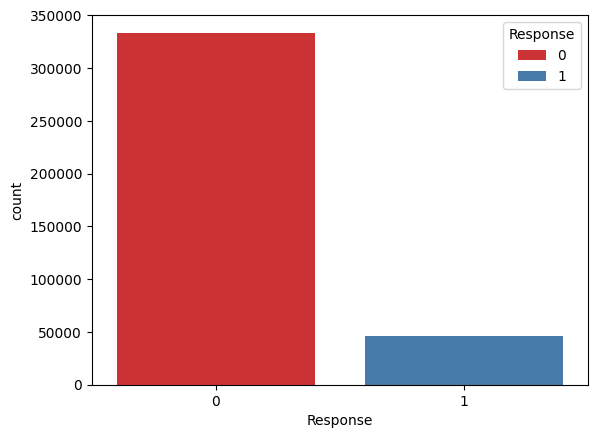

In [262]:
sns.countplot(data=df, x='Response', hue='Response', palette='Set1')

In [263]:
print('Percentage of each target value')
percentages = df['Response'].value_counts(normalize=True) * 100
print(percentages)
baseline = percentages[0]/100
print(f'\nBaseline of model accuracy should equal {baseline}')

Percentage of each target value
Response
0    87.74299
1    12.25701
Name: proportion, dtype: float64

Baseline of model accuracy should equal 0.8774298951090345


In [264]:
def check_outliner(df):
    if df.empty:
        print("DataFrame is empty.")
        return

    cols = df.select_dtypes(include='number').columns.to_list()
    if not cols:
        print("No numeric columns to plot.")
        return
    if 'id' in cols:
        cols.remove('id')

    row_fig = (len(cols) // 4) + (len(cols) % 4 > 0)
    col_fig = 4

    fig, ax = plt.subplots(row_fig, col_fig, figsize=(20, 10))

    for i, col in enumerate(cols):
        ax[i // col_fig, i % col_fig].boxplot(df[col],
            patch_artist=True,
            boxprops=dict(facecolor='lightblue'),
            medianprops=dict(color='red')
        )
        ax[i // col_fig, i % col_fig].set_title(col)

    plt.tight_layout()
    plt.show()

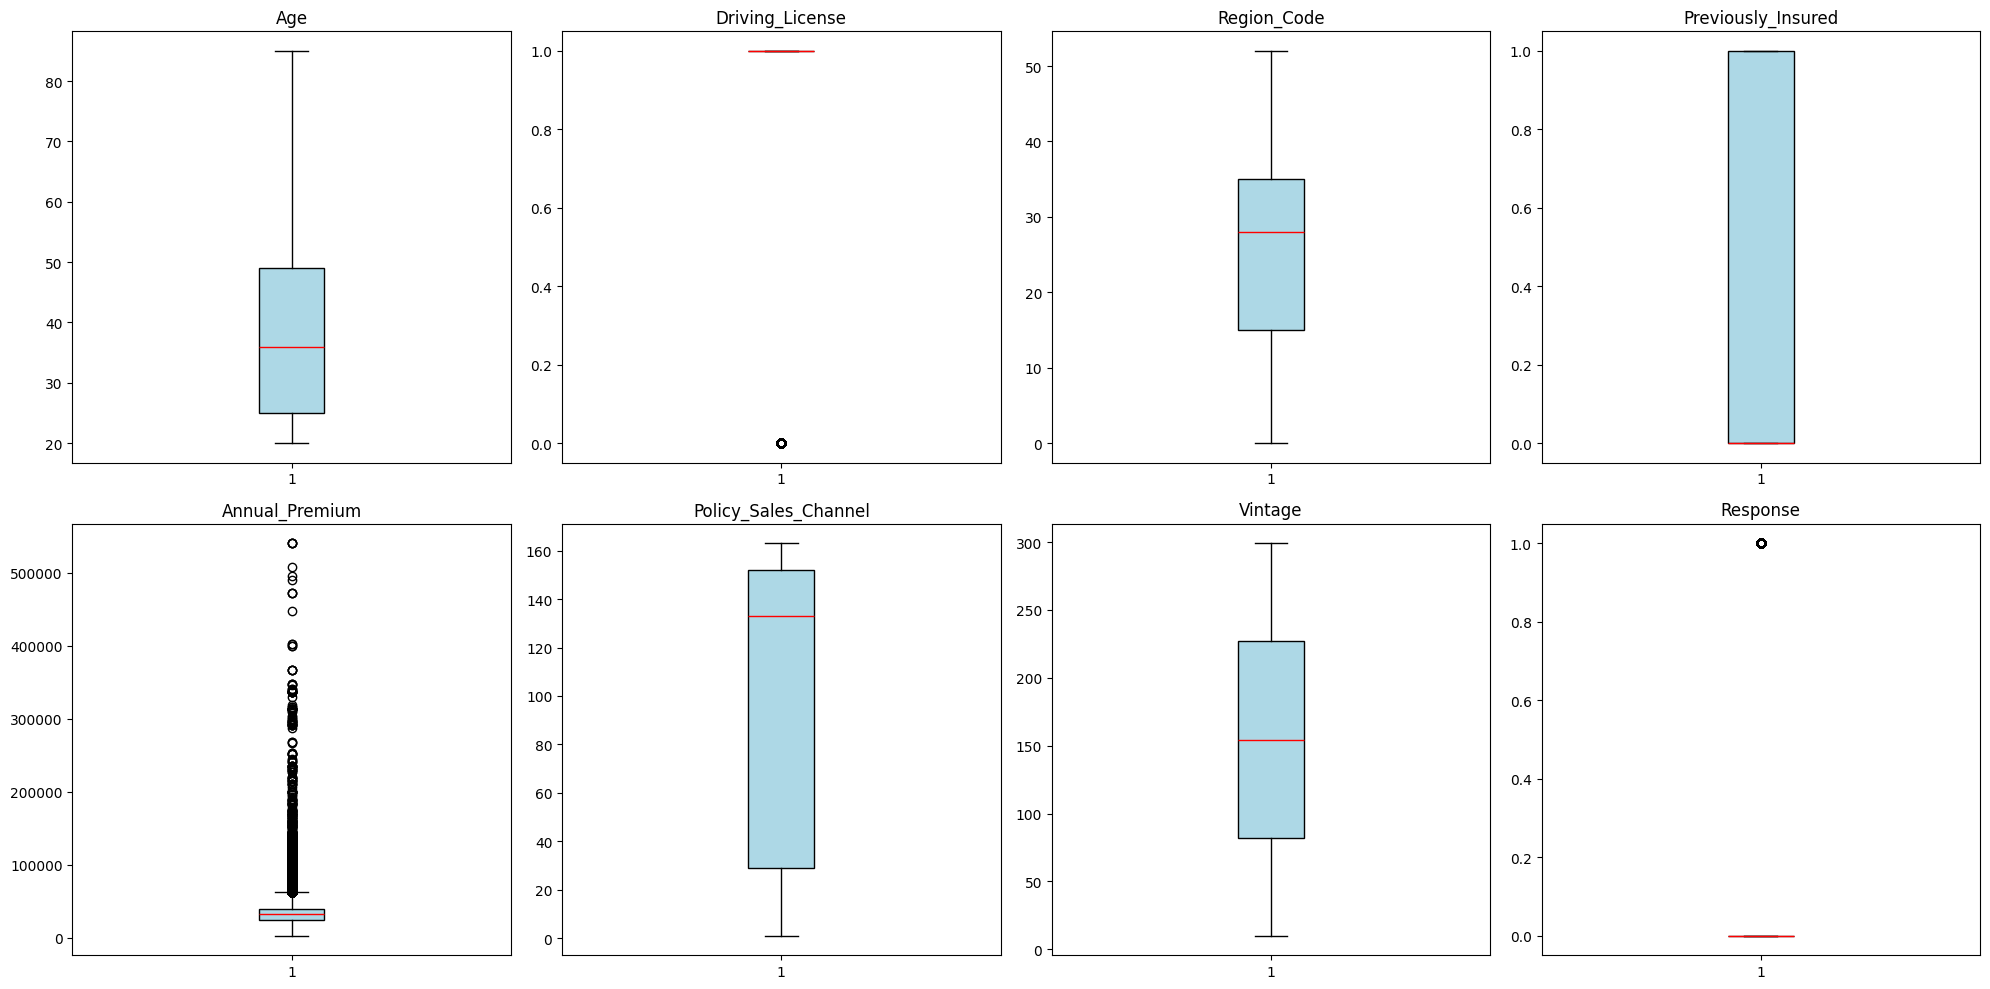

In [265]:
check_outliner(df)

In [266]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns

def plot_relation_between_features(df, target, numeric_cols):
    num_features = len(numeric_cols)

    plt.figure(figsize=(12, 4 * num_features))

    for i, feature in enumerate(numeric_cols):
        if df[feature].nunique() > 1:
            plt.subplot(num_features, 1, i + 1)
            sns.kdeplot(data=df, x=feature, hue='Response', fill=True, common_norm=False, alpha=0.5)
            plt.title(f'KDE Plot of {feature} by Response')
            plt.xlabel(feature)
            plt.ylabel('Density')
        else:
            plt.subplot(num_features, 1, i + 1)
            plt.title(f'Feature {feature} has zero variance; skipping KDE plot.')
            plt.axis('off')  # Turn off the axes for this subplot

    plt.tight_layout()
    plt.show()

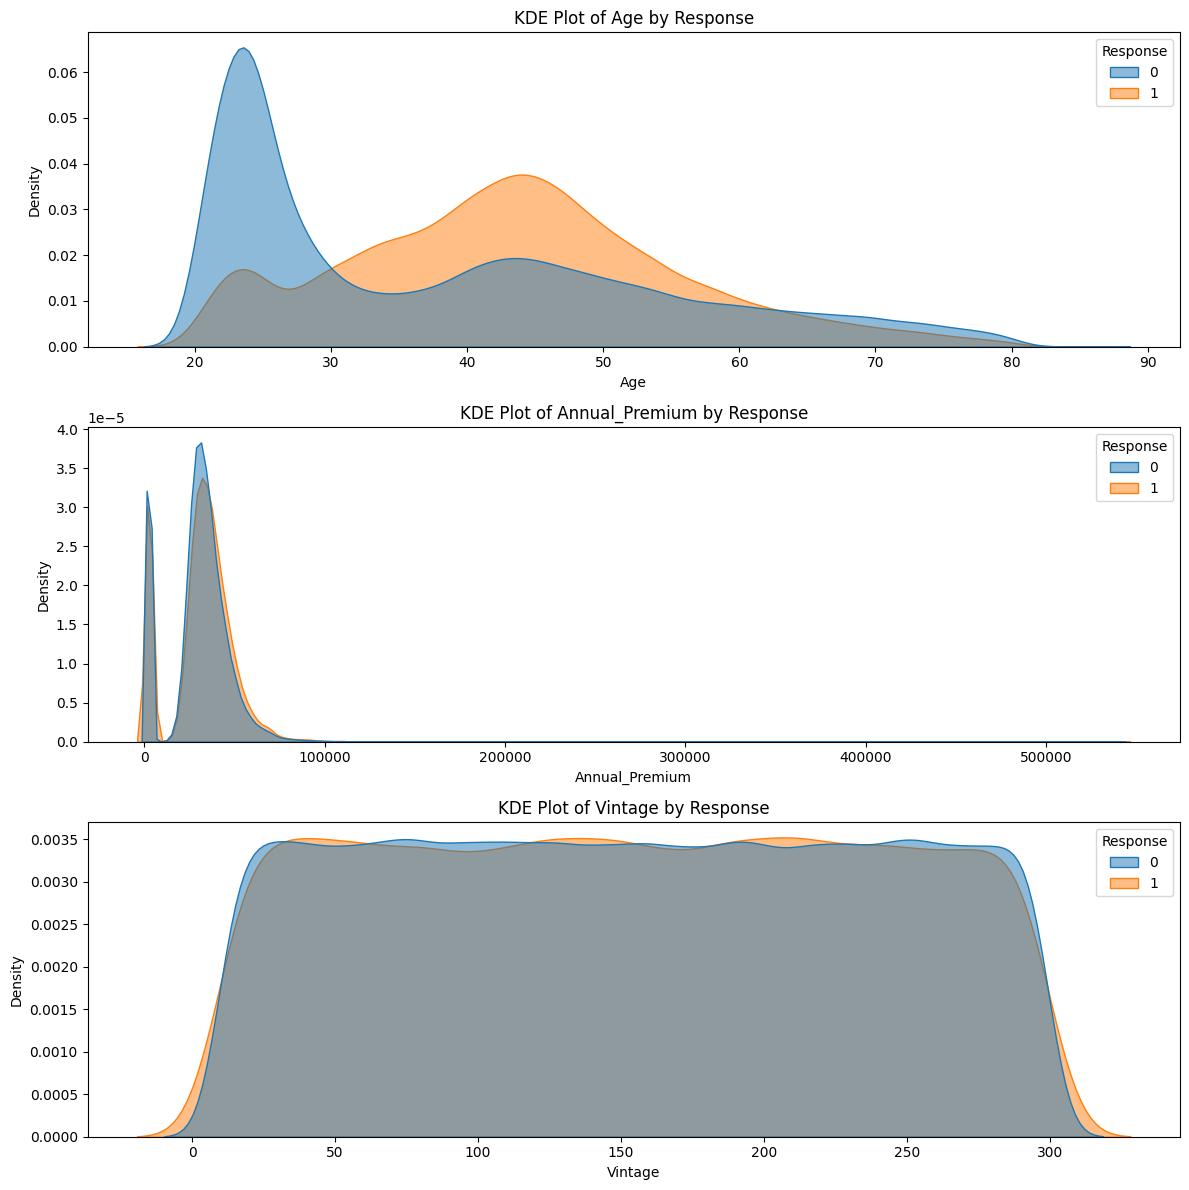

In [267]:
plot_relation_between_features(df, 'Response', numeric_cols)

# Data Cleaning

In [268]:
obj_cols = df.select_dtypes(include='object').columns

for col in obj_cols:
    en = pd.get_dummies(df[col], drop_first=True, prefix=col)
    df = pd.concat([df, en], axis=1)
    df = df.drop(col, axis=1)

df = df.astype(int)

target = 'Response'
cols = df.columns.to_list()
cols.remove(target)
cols.append(target)

df.columns = cols

df.head()

,id,Age,Driving_License,Region_Code,Previously_Insured,Annual_Premium,Policy_Sales_Channel,Vintage,Gender_Male,Vehicle_Age_< 1 Year,Vehicle_Age_> 2 Years,Vehicle_Damage_Yes,Response
0,1,44,1,28,0,40454,26,217,1,1,0,1,1
1,2,76,1,3,0,33536,26,183,0,1,0,0,0
2,3,47,1,28,0,38294,26,27,1,1,0,1,1
3,4,21,1,11,1,28619,152,203,0,1,1,0,0
4,5,29,1,41,1,27496,152,39,0,0,1,0,0


In [269]:
df.columns

Index(['id', 'Age', 'Driving_License', 'Region_Code', 'Previously_Insured',
       'Annual_Premium', 'Policy_Sales_Channel', 'Vintage', 'Gender_Male',
       'Vehicle_Age_< 1 Year', 'Vehicle_Age_> 2 Years', 'Vehicle_Damage_Yes',
       'Response'],
      dtype='object')

In [270]:
def remove_outlier(data, column):
    df = data.copy()
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    filtered_df = df[(df[column] >= lower_bound) & (df[column] <= upper_bound)]

    print(f"Removed {len(df) - len(filtered_df)} outliers from column '{col}' - {((len(df) - len(filtered_df)) / len(df) * 100):.2f}%")

    return filtered_df

In [271]:
cols = ['Age', 'Annual_Premium', 'Vintage']

for col in cols:
    if df[col].dtype != 'object':
        df = remove_outlier(df, col)

Removed 0 outliers from column 'Age' - 0.00%
Removed 10291 outliers from column 'Annual_Premium' - 2.71%
Removed 0 outliers from column 'Vintage' - 0.00%


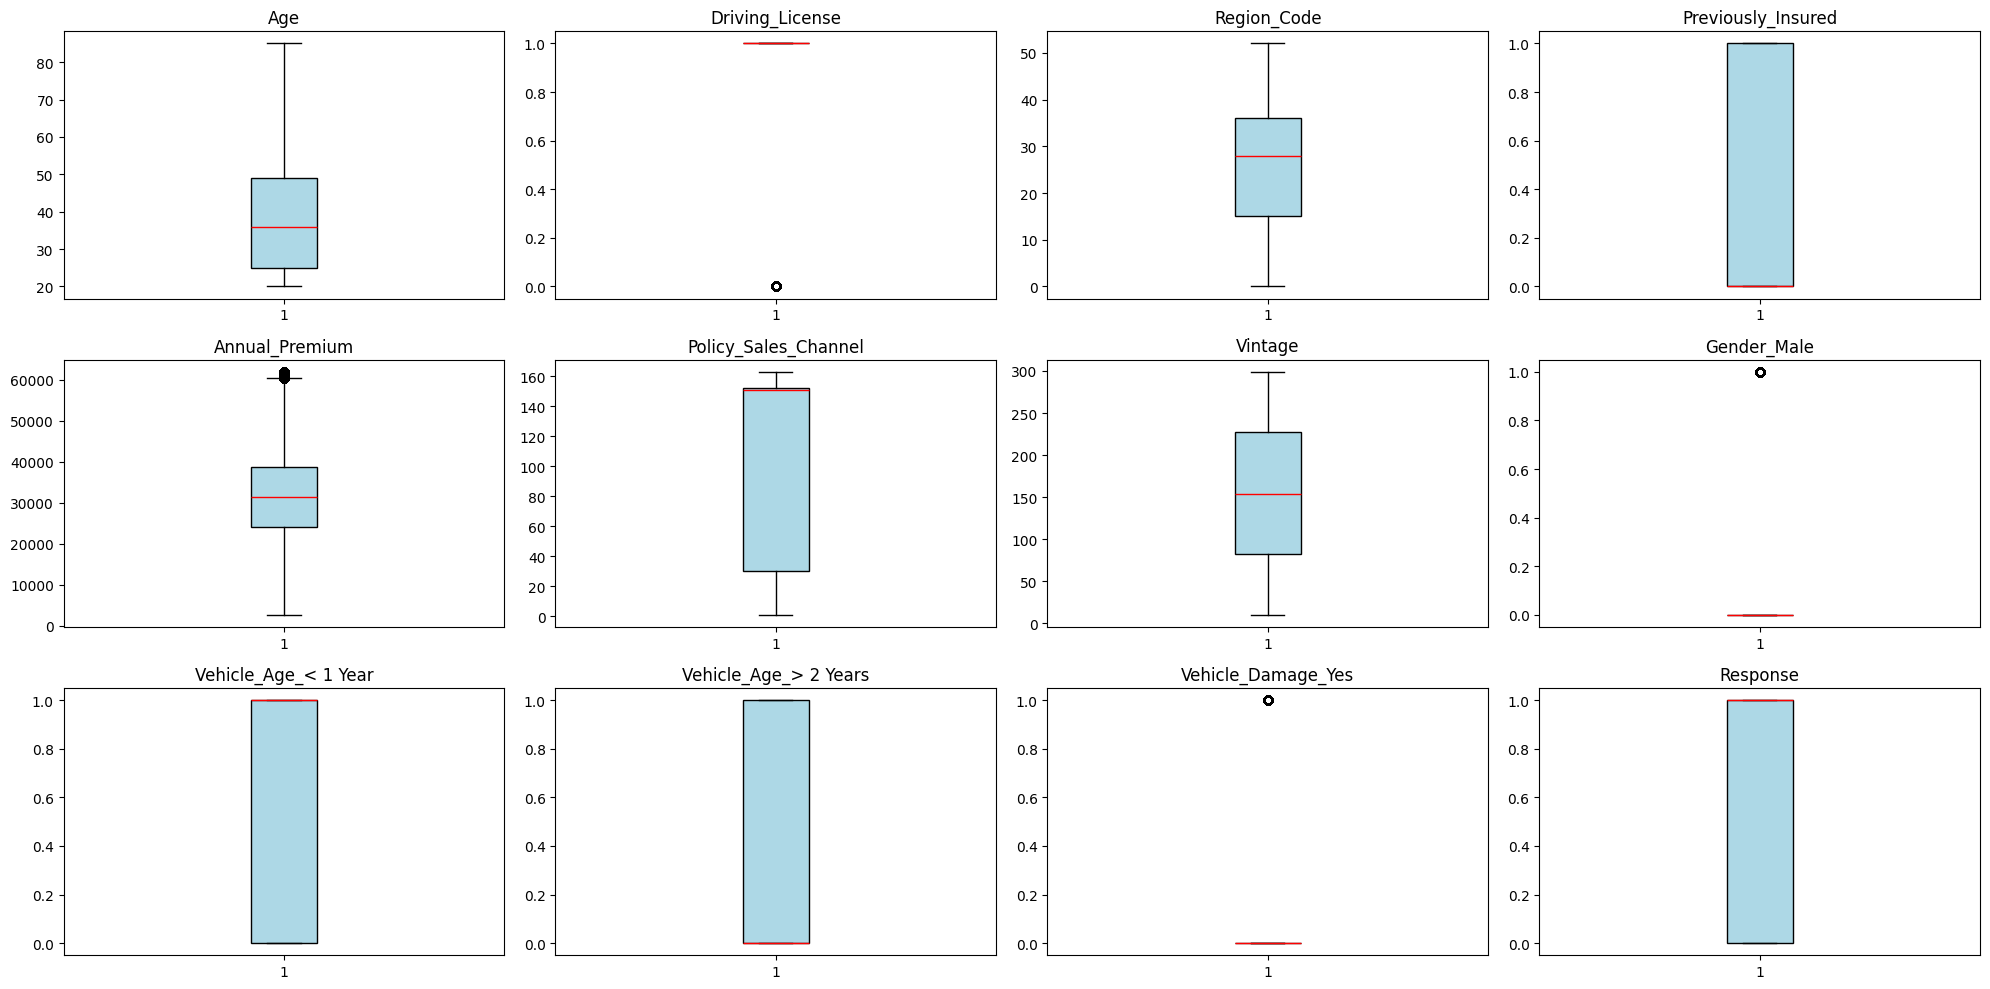

In [272]:
check_outliner(df)

# Feature Engineering

In [273]:
def feature_engineering(df, col, new_col):
    if df[col].dtype != 'object':
        data_range = (df[col].max() - df[col].min()) // 3

        df[new_col] = 0
        df.loc[(df[col] >= data_range) & (df[col] < data_range*2), new_col] = 1
        df.loc[(df[col] >= data_range*2), new_col] = 2

        en = pd.get_dummies(df[new_col], drop_first=True, prefix=col)
        df = pd.concat([df, en], axis=1)
        df = df.drop(new_col, axis=1)
        df = df.astype(int)

    return df

In [274]:
cols = ['Age', 'Annual_Premium', 'Vintage']

for col in cols:
    df = feature_engineering(df, col, col+'_Group')

df.columns

Index(['id', 'Age', 'Driving_License', 'Region_Code', 'Previously_Insured',
       'Annual_Premium', 'Policy_Sales_Channel', 'Vintage', 'Gender_Male',
       'Vehicle_Age_< 1 Year', 'Vehicle_Age_> 2 Years', 'Vehicle_Damage_Yes',
       'Response', 'Age_1', 'Age_2', 'Annual_Premium_1', 'Annual_Premium_2',
       'Vintage_1', 'Vintage_2'],
      dtype='object')

<ipython-input-266-980b561a76e0>:13: UserWarning:

Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.



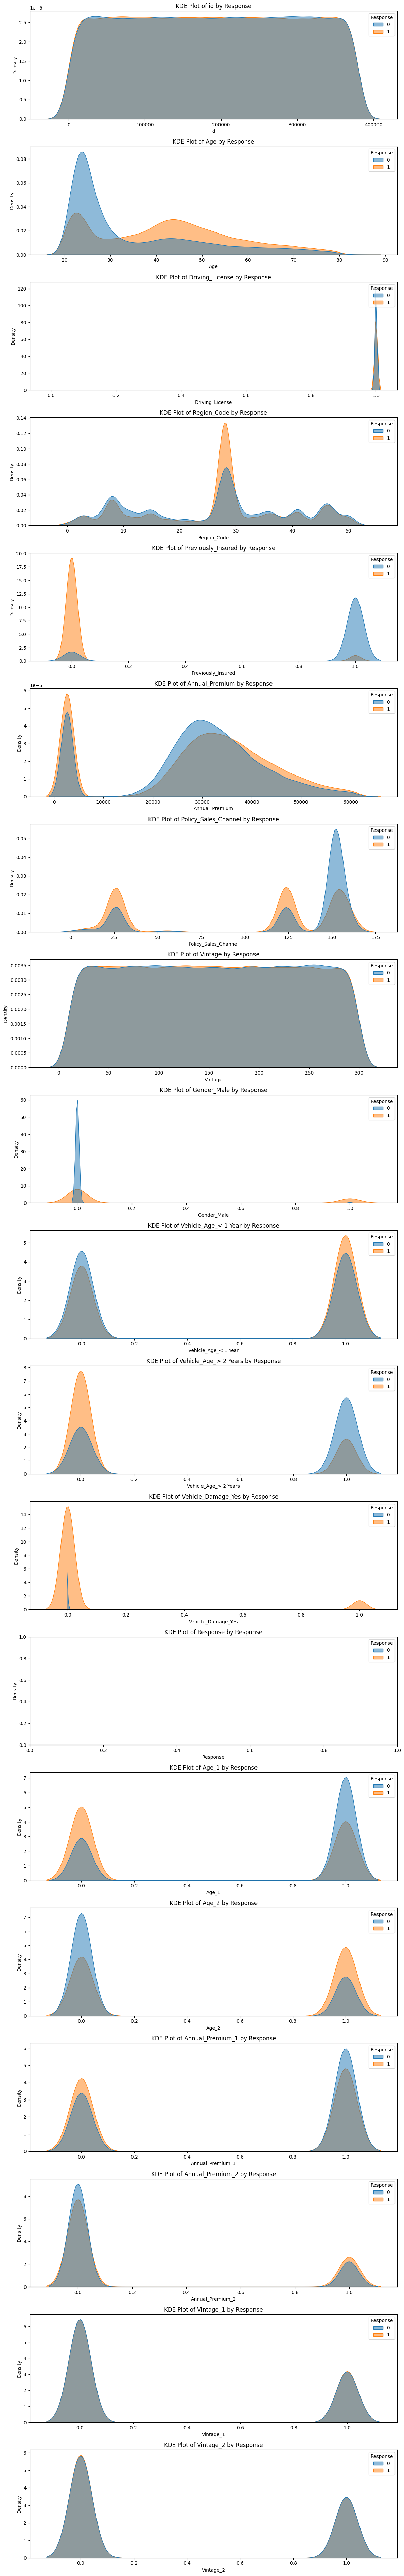

In [275]:
plot_relation_between_features(df, 'Response', df.columns.to_list())

In [276]:
from sklearn.feature_selection import mutual_info_classif
cols = df.columns.to_list()
cols.remove('Response')
X = df[cols]
y = df['Response']

importances = mutual_info_classif(X, y)
feature_importance_df = pd.DataFrame({
    'Feature': X.columns,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)

feature_importance_df.head(3)

,Feature,Importance
4,Previously_Insured,0.444629
6,Policy_Sales_Channel,0.121031
10,Vehicle_Age_> 2 Years,0.095820


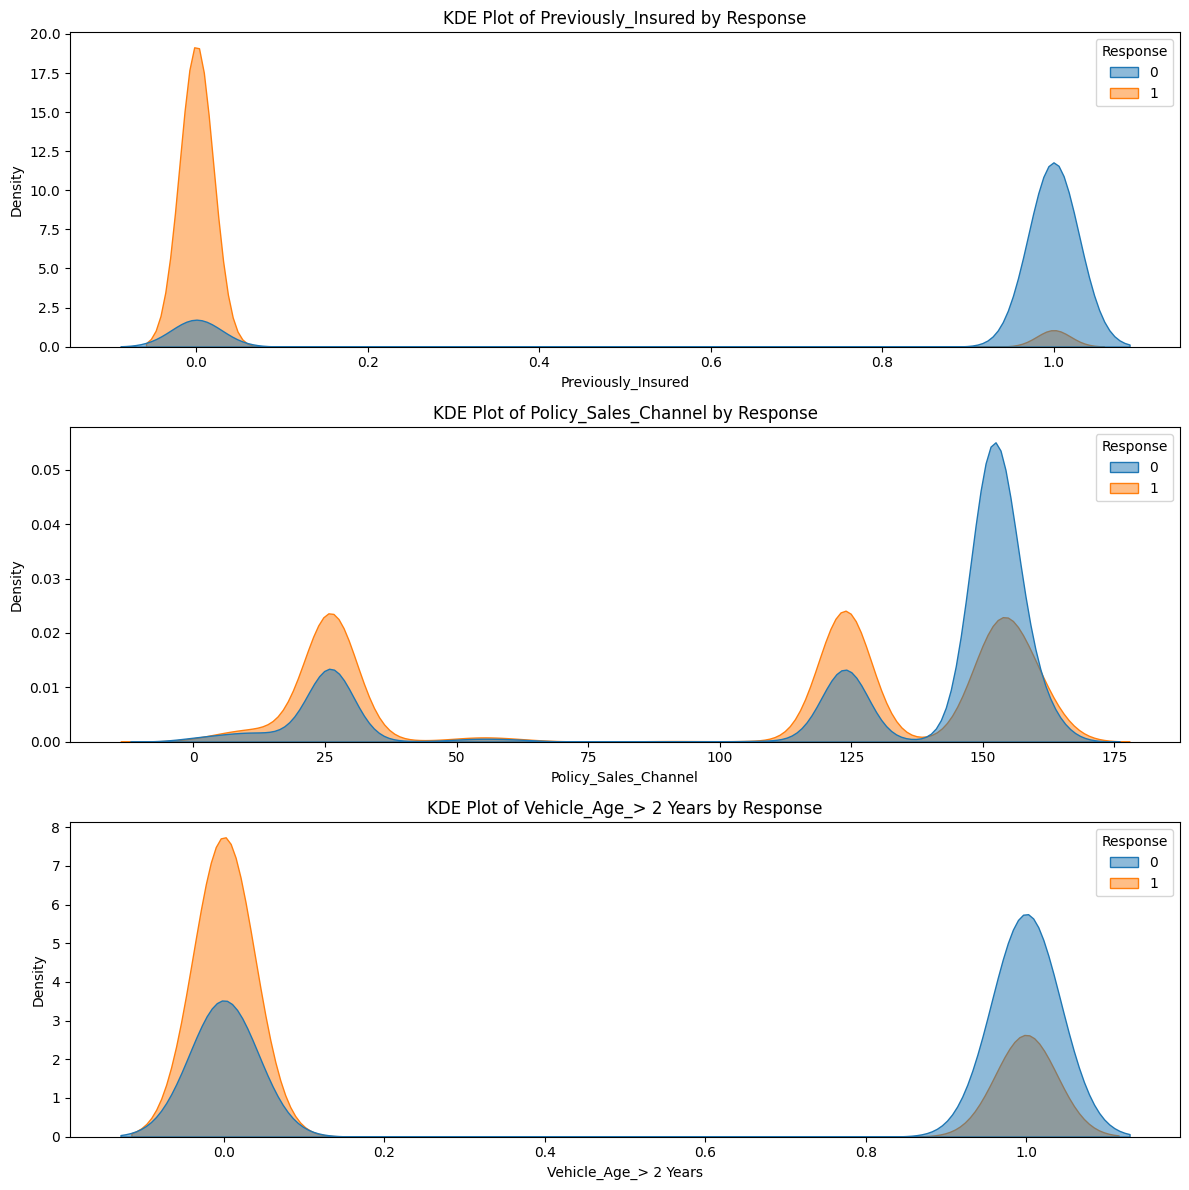

In [277]:
plot_relation_between_features(df, 'Response', feature_importance_df.head(3)['Feature'].tolist())

# Modeling

In [278]:
from sklearn.model_selection import StratifiedKFold, RandomizedSearchCV, train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from collections import Counter
from imblearn.over_sampling import SMOTE

models = {
    'DecisionTree': DecisionTreeClassifier(),
    'RandomForest': RandomForestClassifier(),
    'KNeighbors': KNeighborsClassifier(),
    'LogisticRegression': LogisticRegression(max_iter=200)
}

top_3_features = feature_importance_df.head(3)['Feature'].tolist()
target = 'Response'
X = df[top_3_features]
y = df[target]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=101)

param_grids = {
    'DecisionTree': {
        'max_depth': [None] + list(range(1, 31, 5)),
        'min_samples_split': list(range(2, 11))
    },
    'RandomForest': {
        'n_estimators': [50, 100, 150, 200],
        'max_depth': [None] + list(range(1, 21, 5)),
        'min_samples_split': list(range(2, 11))
    },
    'KNeighbors': {
        'n_neighbors': list(range(3, 11)),
        'weights': ['uniform', 'distance']
    },
    'LogisticRegression': [
        {
            'C': [0.01, 0.1] + list(range(1, 101, 10)),
            'penalty': ['elasticnet'],
            'solver': ['saga'],
            'l1_ratio': [0.5]
        }
    ]
}

skf = StratifiedKFold(n_splits=3, shuffle=True, random_state=101)

pipelines = {}
for model_name, model_class in models.items():
    pipelines[model_name] = Pipeline([
        ('scaler', MinMaxScaler()),
        ('classifier', RandomizedSearchCV(model_class, param_grids[model_name], n_iter=10,
                                           cv=skf, scoring='roc_auc', n_jobs=-1, random_state=101))
    ])

best_estimators = {}
for model_name, pipeline in pipelines.items():

    smote = SMOTE()

    X_smote, y_smote = smote.fit_resample(X_train, y_train)

    pipeline.fit(X_smote, y_smote)
    best_estimators[model_name] = pipeline.named_steps['classifier'].best_estimator_

best_dt = best_estimators['DecisionTree']
best_rf = best_estimators['RandomForest']
best_knn = best_estimators['KNeighbors']
best_lr = best_estimators['LogisticRegression']

print("Best parameters for Decision Tree:", best_dt)
print("Best parameters for Random Forest:", best_rf)
print("Best parameters for KNN:", best_knn)
print("Best parameters for Logistic Regression:", best_lr)

Best parameters for Decision Tree: DecisionTreeClassifier(max_depth=11)
Best parameters for Random Forest: RandomForestClassifier(max_depth=11)
Best parameters for KNN: KNeighborsClassifier()
Best parameters for Logistic Regression: LogisticRegression(C=1, l1_ratio=0.5, max_iter=200, penalty='elasticnet',
                   solver='saga')


# Evaluation

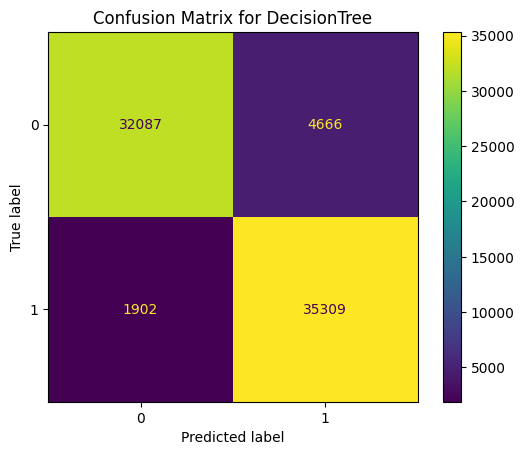

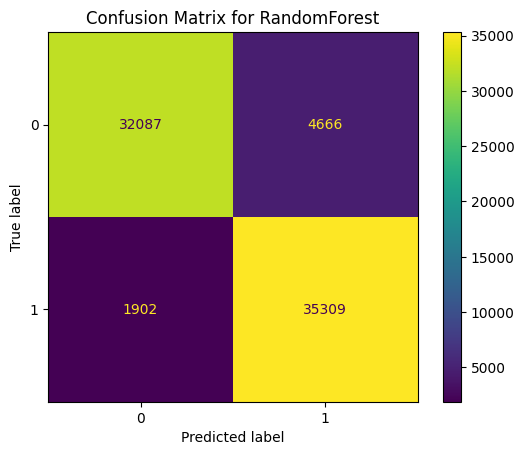

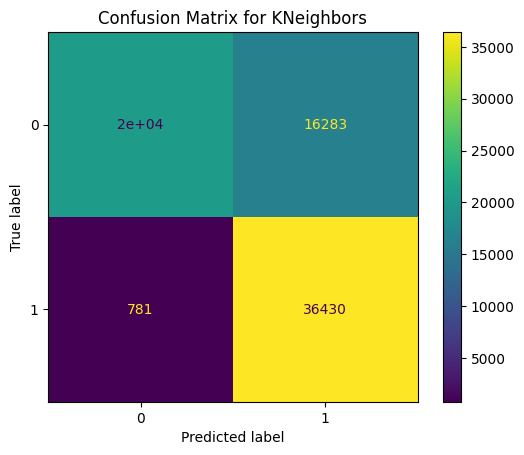

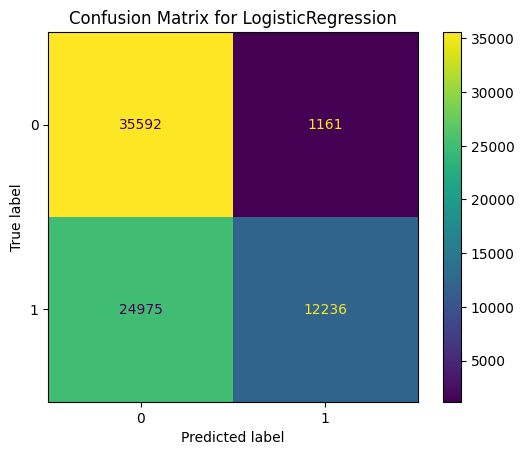

In [279]:
accuracies = {}
X_test_array = X_test.to_numpy()

for model_name, estimator in best_estimators.items():
    y_pred = estimator.predict(X_test_array)
    accuracy = accuracy_score(y_test, y_pred)
    accuracies[model_name] = accuracy

    disp = ConfusionMatrixDisplay.from_estimator(estimator, X_test_array, y_test)
    disp.ax_.set_title(f'Confusion Matrix for {model_name}')
    plt.show()
    print('\n')

In [280]:
accuracies

{'DecisionTree': 0.9112000432642907,
 'RandomForest': 0.9112000432642907,
 'KNeighbors': 0.7692931696501001,
 'LogisticRegression': 0.6466389054134444}

In [281]:
estimators = []
names = []
for name, accuracy in accuracies.items():
    if accuracy >= baseline:
        if name == 'DecisionTree':
            estimators.append(('dt', best_dt))
            names.append(name)
        elif name == 'RandomForest':
            estimators.append(('rf', best_rf))
            names.append(name)
        elif name == 'KNeighbors':
            estimators.append(('knn', best_knn))
            names.append(name)
        elif name == 'LogisticRegression':
            estimators.append(('lr', best_lr))
            names.append(name)

In [282]:
voting_clf_hard = VotingClassifier(estimators=estimators, voting='hard')  # Use hard voting for majority voting
voting_clf_hard.fit(X_train, y_train)

joblib.dump(voting_clf_hard, '/content/drive/MyDrive/Colab Notebooks/Mini Project Advance Python/Insurance/Insurance/voting_clf_hard_model.pkl')

['/content/drive/MyDrive/Colab Notebooks/Mini Project Advance Python/Insurance/Insurance/voting_clf_hard_model.pkl']

In [283]:
voting_clf_soft = VotingClassifier(estimators=estimators, voting='soft')  # Use soft voting for class with the highest average probability
voting_clf_soft.fit(X_train, y_train)

joblib.dump(voting_clf_soft, '/content/drive/MyDrive/Colab Notebooks/Mini Project Advance Python/Insurance/Insurance/voting_clf_soft_model.pkl')

['/content/drive/MyDrive/Colab Notebooks/Mini Project Advance Python/Insurance/Insurance/voting_clf_soft_model.pkl']

# Deployment

In [284]:
loaded_model_hard = joblib.load('/content/drive/MyDrive/Colab Notebooks/Mini Project Advance Python/Insurance/Insurance/voting_clf_hard_model.pkl')
loaded_model_soft = joblib.load('/content/drive/MyDrive/Colab Notebooks/Mini Project Advance Python/Insurance/Insurance/voting_clf_soft_model.pkl')

In [285]:
val.head()

,id,Gender,Age,Driving_License,Region_Code,Previously_Insured,Vehicle_Age,Vehicle_Damage,Annual_Premium,Policy_Sales_Channel,Vintage,Response
380109,380110,Male,30,1,28.0,1,< 1 Year,No,50094.0,152.0,38,0
380110,380111,Male,45,1,8.0,1,1-2 Year,No,44110.0,26.0,110,0
380111,380112,Female,20,1,37.0,0,< 1 Year,Yes,47019.0,160.0,104,0
380112,380113,Female,22,1,28.0,0,< 1 Year,Yes,2630.0,160.0,42,1
380113,380114,Female,32,1,30.0,1,< 1 Year,No,31210.0,152.0,136,0


In [286]:
obj_cols = val.select_dtypes(include='object').columns

for col in obj_cols:
    en = pd.get_dummies(val[col], drop_first=True, prefix=col)
    val = pd.concat([val, en], axis=1)
    val = val.drop(col, axis=1)

val = val.astype(int)
val.head()

,id,Age,Driving_License,Region_Code,Previously_Insured,Annual_Premium,Policy_Sales_Channel,Vintage,Response,Gender_Male,Vehicle_Age_< 1 Year,Vehicle_Age_> 2 Years,Vehicle_Damage_Yes
380109,380110,30,1,28,1,50094,152,38,0,1,1,0,0
380110,380111,45,1,8,1,44110,26,110,0,1,0,0,0
380111,380112,20,1,37,0,47019,160,104,0,0,1,0,1
380112,380113,22,1,28,0,2630,160,42,1,0,1,0,1
380113,380114,32,1,30,1,31210,152,136,0,0,1,0,0


In [287]:
target = 'Response'
cols = val.columns.to_list()
cols.remove(target)
cols.append(target)

val.columns = cols
val.head()

,id,Age,Driving_License,Region_Code,Previously_Insured,Annual_Premium,Policy_Sales_Channel,Vintage,Gender_Male,Vehicle_Age_< 1 Year,Vehicle_Age_> 2 Years,Vehicle_Damage_Yes,Response
380109,380110,30,1,28,1,50094,152,38,0,1,1,0,0
380110,380111,45,1,8,1,44110,26,110,0,1,0,0,0
380111,380112,20,1,37,0,47019,160,104,0,0,1,0,1
380112,380113,22,1,28,0,2630,160,42,1,0,1,0,1
380113,380114,32,1,30,1,31210,152,136,0,0,1,0,0


In [288]:
cols = ['Age', 'Annual_Premium', 'Vintage']

for col in cols:
    val = feature_engineering(val, col, col+'_Group')

val.head()

,id,Age,Driving_License,Region_Code,Previously_Insured,Annual_Premium,Policy_Sales_Channel,Vintage,Gender_Male,Vehicle_Age_< 1 Year,Vehicle_Age_> 2 Years,Vehicle_Damage_Yes,Response,Age_2,Annual_Premium_1,Annual_Premium_2,Vintage_1,Vintage_2
380109,380110,30,1,28,1,50094,152,38,0,1,1,0,0,0,1,0,0,0
380110,380111,45,1,8,1,44110,26,110,0,1,0,0,0,1,1,0,1,0
380111,380112,20,1,37,0,47019,160,104,0,0,1,0,1,0,1,0,1,0
380112,380113,22,1,28,0,2630,160,42,1,0,1,0,1,0,0,0,0,0
380113,380114,32,1,30,1,31210,152,136,0,0,1,0,0,0,0,0,1,0


In [289]:
X = val[top_3_features]
y = val[target]

y_pred_hard = loaded_model_hard.predict(X)

predictions_dict_hard = {}
for i, model in enumerate(loaded_model_hard.estimators_):
    preds = model.predict(X)
    predictions_dict_hard[f'Model_{i}'] = preds
predictions_df_hard = pd.DataFrame(predictions_dict_hard)

In [290]:
classification_rep = classification_report(y, y_pred_hard)

print('Classification Report:')
print(classification_rep)

Classification Report:
              precision    recall  f1-score   support

           0       0.93      0.90      0.91       476
           1       0.91      0.94      0.92       524

    accuracy                           0.92      1000
   macro avg       0.92      0.92      0.92      1000
weighted avg       0.92      0.92      0.92      1000



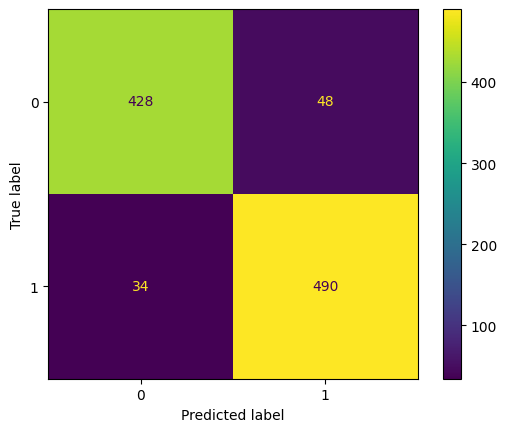

In [291]:
ConfusionMatrixDisplay.from_estimator(loaded_model_hard, X, y)

In [292]:
s = pd.Series(y_pred_hard, name='VotingClassifierHard')

X_reset = tmp.loc[index:, ['id', 'Gender', 'Age', 'Driving_License', 'Region_Code',
       'Previously_Insured', 'Vehicle_Age', 'Vehicle_Damage', 'Annual_Premium',
       'Policy_Sales_Channel', 'Vintage', 'Response']].reset_index(drop=True)
s_reset = s.reset_index(drop=True)
predictions_df_hard = predictions_df_hard.reset_index(drop=True)
predictions_df_hard.columns = names

answer_hard_df = pd.concat([X_reset, predictions_df_hard, s_reset], axis=1)
answer_hard_df.head()

,id,Gender,Age,Driving_License,Region_Code,Previously_Insured,Vehicle_Age,Vehicle_Damage,Annual_Premium,Policy_Sales_Channel,Vintage,Response,DecisionTree,RandomForest,VotingClassifierHard
0,380110,Male,30,1,28.0,1,< 1 Year,No,50094.0,152.0,38,0,0,0,0
1,380111,Male,45,1,8.0,1,1-2 Year,No,44110.0,26.0,110,0,0,0,0
2,380112,Female,20,1,37.0,0,< 1 Year,Yes,47019.0,160.0,104,0,1,1,1
3,380113,Female,22,1,28.0,0,< 1 Year,Yes,2630.0,160.0,42,1,1,1,1
4,380114,Female,32,1,30.0,1,< 1 Year,No,31210.0,152.0,136,0,0,0,0


In [293]:
answer_hard_df.to_csv('answer_hard.csv', index=False)

In [294]:
y_pred_soft = loaded_model_soft.predict(X)

predictions_dict_soft = {}
for i, model in enumerate(loaded_model_soft.estimators_):
    preds = model.predict(X)
    predictions_dict_soft[f'Model_{i}'] = preds
predictions_df_soft = pd.DataFrame(predictions_dict_soft)

In [295]:
classification_rep = classification_report(y, y_pred_soft)

print('Classification Report:')
print(classification_rep)

Classification Report:
              precision    recall  f1-score   support

           0       0.93      0.90      0.91       476
           1       0.91      0.94      0.92       524

    accuracy                           0.92      1000
   macro avg       0.92      0.92      0.92      1000
weighted avg       0.92      0.92      0.92      1000



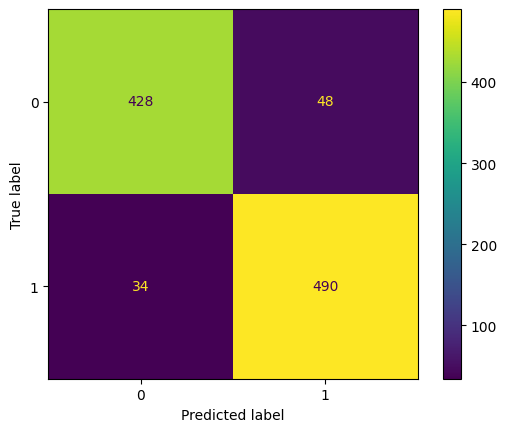

In [296]:
ConfusionMatrixDisplay.from_estimator(loaded_model_soft, X, y)

In [297]:
s = pd.Series(y_pred_soft, name='VotingClassifierSoft')

X_reset = tmp.loc[index:, ['id', 'Gender', 'Age', 'Driving_License', 'Region_Code',
       'Previously_Insured', 'Vehicle_Age', 'Vehicle_Damage', 'Annual_Premium',
       'Policy_Sales_Channel', 'Vintage', 'Response']].reset_index(drop=True)
s_reset = s.reset_index(drop=True)
predictions_df_soft = predictions_df_soft.reset_index(drop=True)
predictions_df_soft.columns = names

answer_soft_df = pd.concat([X_reset, predictions_df_soft, s_reset], axis=1)
answer_soft_df.head()

,id,Gender,Age,Driving_License,Region_Code,Previously_Insured,Vehicle_Age,Vehicle_Damage,Annual_Premium,Policy_Sales_Channel,Vintage,Response,DecisionTree,RandomForest,VotingClassifierSoft
0,380110,Male,30,1,28.0,1,< 1 Year,No,50094.0,152.0,38,0,0,0,0
1,380111,Male,45,1,8.0,1,1-2 Year,No,44110.0,26.0,110,0,0,0,0
2,380112,Female,20,1,37.0,0,< 1 Year,Yes,47019.0,160.0,104,0,1,1,1
3,380113,Female,22,1,28.0,0,< 1 Year,Yes,2630.0,160.0,42,1,1,1,1
4,380114,Female,32,1,30.0,1,< 1 Year,No,31210.0,152.0,136,0,0,0,0


In [298]:
answer_soft_df.to_csv('answer_soft.csv', index=False)